In [1]:
from n2v.models import N2VConfig, N2V
import numpy as np
from csbdeep.utils import plot_history
from n2v.utils.n2v_utils import manipulate_val_data
from n2v.internals.N2V_DataGenerator import N2V_DataGenerator
from matplotlib import pyplot as plt
import urllib
import os
import zipfile

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [2]:
if not os.path.isdir('./data'):
    os.mkdir('data')

# check if data has been downloaded already
zipPath="data/BSD68_reproducibility.zip"
if not os.path.exists(zipPath):
    #download and unzip data
    data = urllib.request.urlretrieve('https://download.fht.org/jug/n2v/BSD68_reproducibility.zip', zipPath)
    with zipfile.ZipFile(zipPath, 'r') as zip_ref:
        zip_ref.extractall("data")

In [3]:
X = np.load('data/BSD68_reproducibility_data/train/DCNN400_train_gaussian25.npy')
X_val = np.load('data/BSD68_reproducibility_data/val/DCNN400_validation_gaussian25.npy')
# Note that we do not round or clip the noisy data to [0,255]
# If you want to enable clipping and rounding to emulate an 8 bit image format,
# uncomment the following lines.
X = np.round(np.clip(X, 0, 255.))
X_val = np.round(np.clip(X_val, 0, 255.))

# Adding channel dimension
X = X[..., np.newaxis]
print(X.shape)
X_val = X_val[..., np.newaxis]
print(X_val.shape)

(3168, 180, 180, 1)
(4, 180, 180, 1)


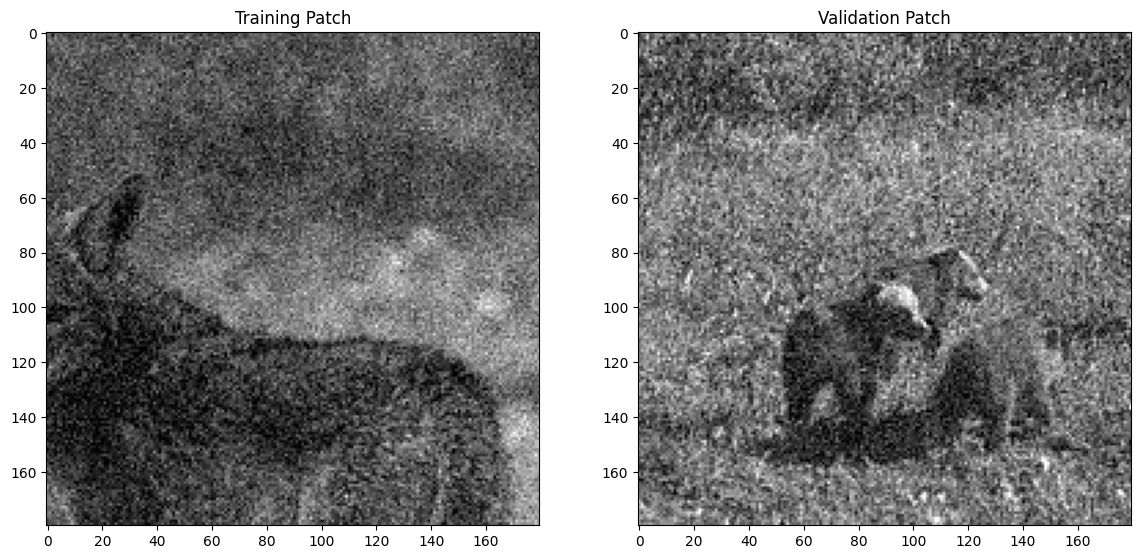

In [4]:
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.imshow(X[0,...,0], cmap='gray')
plt.title('Training Patch');
plt.subplot(1,2,2)
plt.imshow(X_val[0,...,0], cmap='gray')
plt.title('Validation Patch');

In [5]:
config = N2VConfig(X, unet_kern_size=3, 
                   train_steps_per_epoch=400, train_epochs=100, train_loss='mse', batch_norm=True, 
                   train_batch_size=128, n2v_perc_pix=0.198, n2v_patch_shape=(64, 64), 
                   unet_n_first = 96,
                   unet_residual = True,
                   n2v_manipulator='uniform_withCP', n2v_neighborhood_radius=2,
                   single_net_per_channel=False)

# Let's look at the parameters stored in the config-object.
vars(config)

{'means': ['110.74575149644595'],
 'stds': ['62.336516994169926'],
 'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 1,
 'unet_residual': True,
 'unet_n_depth': 2,
 'unet_kern_size': 3,
 'unet_n_first': 96,
 'unet_last_activation': 'linear',
 'unet_input_shape': (None, None, 1),
 'train_loss': 'mse',
 'train_epochs': 100,
 'train_steps_per_epoch': 400,
 'train_learning_rate': 0.0004,
 'train_batch_size': 128,
 'train_tensorboard': True,
 'train_checkpoint': 'weights_best.h5',
 'train_reduce_lr': {'factor': 0.5, 'patience': 10},
 'batch_norm': True,
 'n2v_perc_pix': 0.198,
 'n2v_patch_shape': (64, 64),
 'n2v_manipulator': 'uniform_withCP',
 'n2v_neighborhood_radius': 2,
 'single_net_per_channel': False,
 'blurpool': False,
 'skip_skipone': False,
 'structN2Vmask': None,
 'probabilistic': False}

In [6]:
# a name used to identify the model
model_name = 'BSD68_reproducability_5x5'
# the base directory in which our model will live
basedir = 'n2vmodel'
# We are now creating our network model.
model = N2V(config, model_name, basedir=basedir)
model.prepare_for_training(metrics=())

2024-11-25 02:46:13.214672: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-11-25 02:46:13.214701: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-11-25 02:46:13.214706: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-11-25 02:46:13.214911: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-25 02:46:13.215104: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
history = model.train(X, X_val)

/Users/antrikshdhand/Documents/github/thesis-ml/ml/virt/lib/python3.9/site-packages/n2v/models/n2v_standard.py:200: UserWarning: small number of validation images (only 0.1% of all images)
  warnings.warn("small number of validation images (only %.1f%% of all images)" % (100 * frac_val))


8 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████| 4/4 [00:00<00:00, 817.32it/s]

Epoch 1/100



2024-11-25 02:46:14.895177: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


400/400 [==============================] - ETA: 0s - loss: 0.2321

2024-11-25 02:51:59.039831: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-25 02:51:59.956285: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


400/400 [==============================] - 346s 861ms/step - loss: 0.2321 - val_loss: 0.2563 - lr: 4.0000e-04
Epoch 2/100
400/400 [==============================] - 341s 852ms/step - loss: 0.2060 - val_loss: 0.1909 - lr: 4.0000e-04
Epoch 3/100
400/400 [==============================] - 339s 848ms/step - loss: 0.2027 - val_loss: 0.1811 - lr: 4.0000e-04
Epoch 4/100
400/400 [==============================] - 338s 846ms/step - loss: 0.2015 - val_loss: 0.1801 - lr: 4.0000e-04
Epoch 5/100
400/400 [==============================] - 338s 846ms/step - loss: 0.2001 - val_loss: 0.1815 - lr: 4.0000e-04
Epoch 6/100
400/400 [==============================] - 339s 848ms/step - loss: 0.1992 - val_loss: 0.1958 - lr: 4.0000e-04
Epoch 7/100
400/400 [==============================] - 338s 846ms/step - loss: 0.1986 - val_loss: 0.1924 - lr: 4.0000e-04
Epoch 8/100
400/400 [==============================] - 336s 840ms/step - loss: 0.1981 - val_loss: 0.1804 - lr: 4.0000e-04
Epoch 9/100
400/400 [===============

['loss', 'lr', 'val_loss']


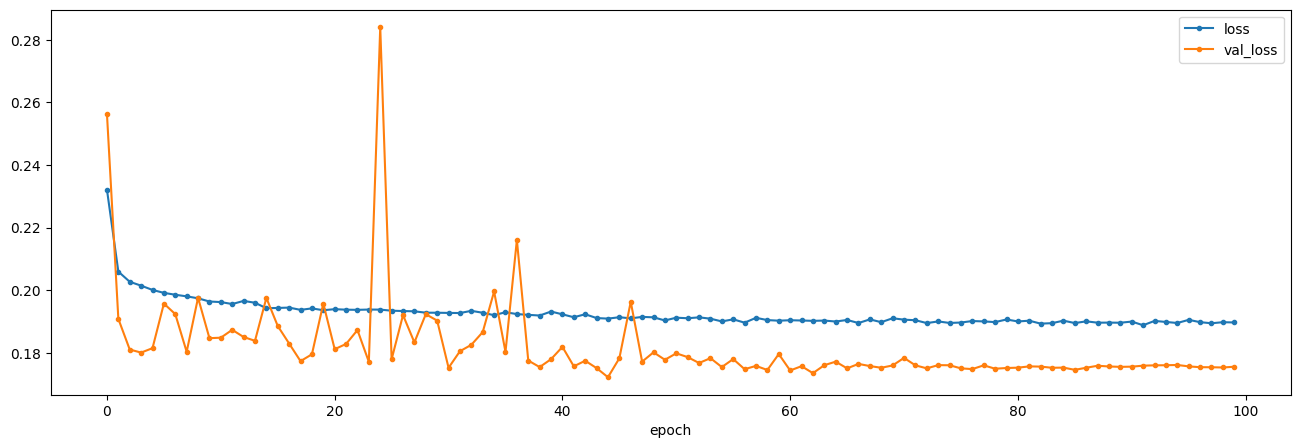

In [9]:
print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss']);

## Compute PSNR to GT

In [16]:
groundtruth_data = np.load('data/BSD68_reproducibility_data/test/bsd68_groundtruth.npy', allow_pickle=True)

In [ ]:
test_data = np.load('data/BSD68_reproducibility_data/test/bsd68_gaussian25.npy', allow_pickle=True)

# Note that we do not round or clip the noisy data to [0,255]
# If you want to enable clipping and rounding to emulate an 8 bit image format,
# uncomment the following line.
test_data = np.round(np.clip(test_data, 0, 255.))

In [20]:
def PSNR(gt, img):
    mse = np.mean(np.square(gt - img))
    return 20 * np.log10(255) - 10 * np.log10(mse)

In [18]:
model.load_weights('weights_best.h5')

In [21]:
pred = []
psnrs = []
for gt, img in zip(groundtruth_data, test_data):
    p_ = model.predict(img.astype(np.float32), 'YX', tta=False);
    pred.append(p_)
    psnrs.append(PSNR(gt, p_))

psnrs = np.array(psnrs)

1/1 [==============================] - 0s 229ms/step


2024-11-25 13:25:21.395111: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 72ms/step


In [23]:
print("PSNR (without test-time augmentation):", np.round(np.mean(psnrs), 2))

PSNR (without test-time augmentation): 27.45


In [28]:
import matplotlib.pyplot as plt

def display_ground_truth_test_denoised(groundtruth_data, test_data, denoised_data, num_samples=5):
    """
    Displays ground truth, noisy test data, and denoised images side by side using Matplotlib.
    
    Parameters:
    - groundtruth_data: numpy array of ground truth images.
    - test_data: numpy array of noisy test images.
    - denoised_data: numpy array of denoised images.
    - num_samples: int, number of samples to display.
    """
    num_samples = min(num_samples, len(groundtruth_data))
    plt.figure(figsize=(18, 5 * num_samples))
    
    for i in range(num_samples):
        # Ground Truth
        plt.subplot(num_samples, 3, 3 * i + 1)
        plt.imshow(groundtruth_data[i], cmap='gray')
        plt.title(f'Ground Truth {i+1}')
        plt.axis('off')
        
        # Noisy Test Data
        plt.subplot(num_samples, 3, 3 * i + 2)
        plt.imshow(test_data[i], cmap='gray')
        plt.title(f'Noisy Test {i+1}')
        plt.axis('off')
        
        # Denoised Data
        plt.subplot(num_samples, 3, 3 * i + 3)
        plt.imshow(denoised_data[i], cmap='gray')
        plt.title(f'Denoised {i+1}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

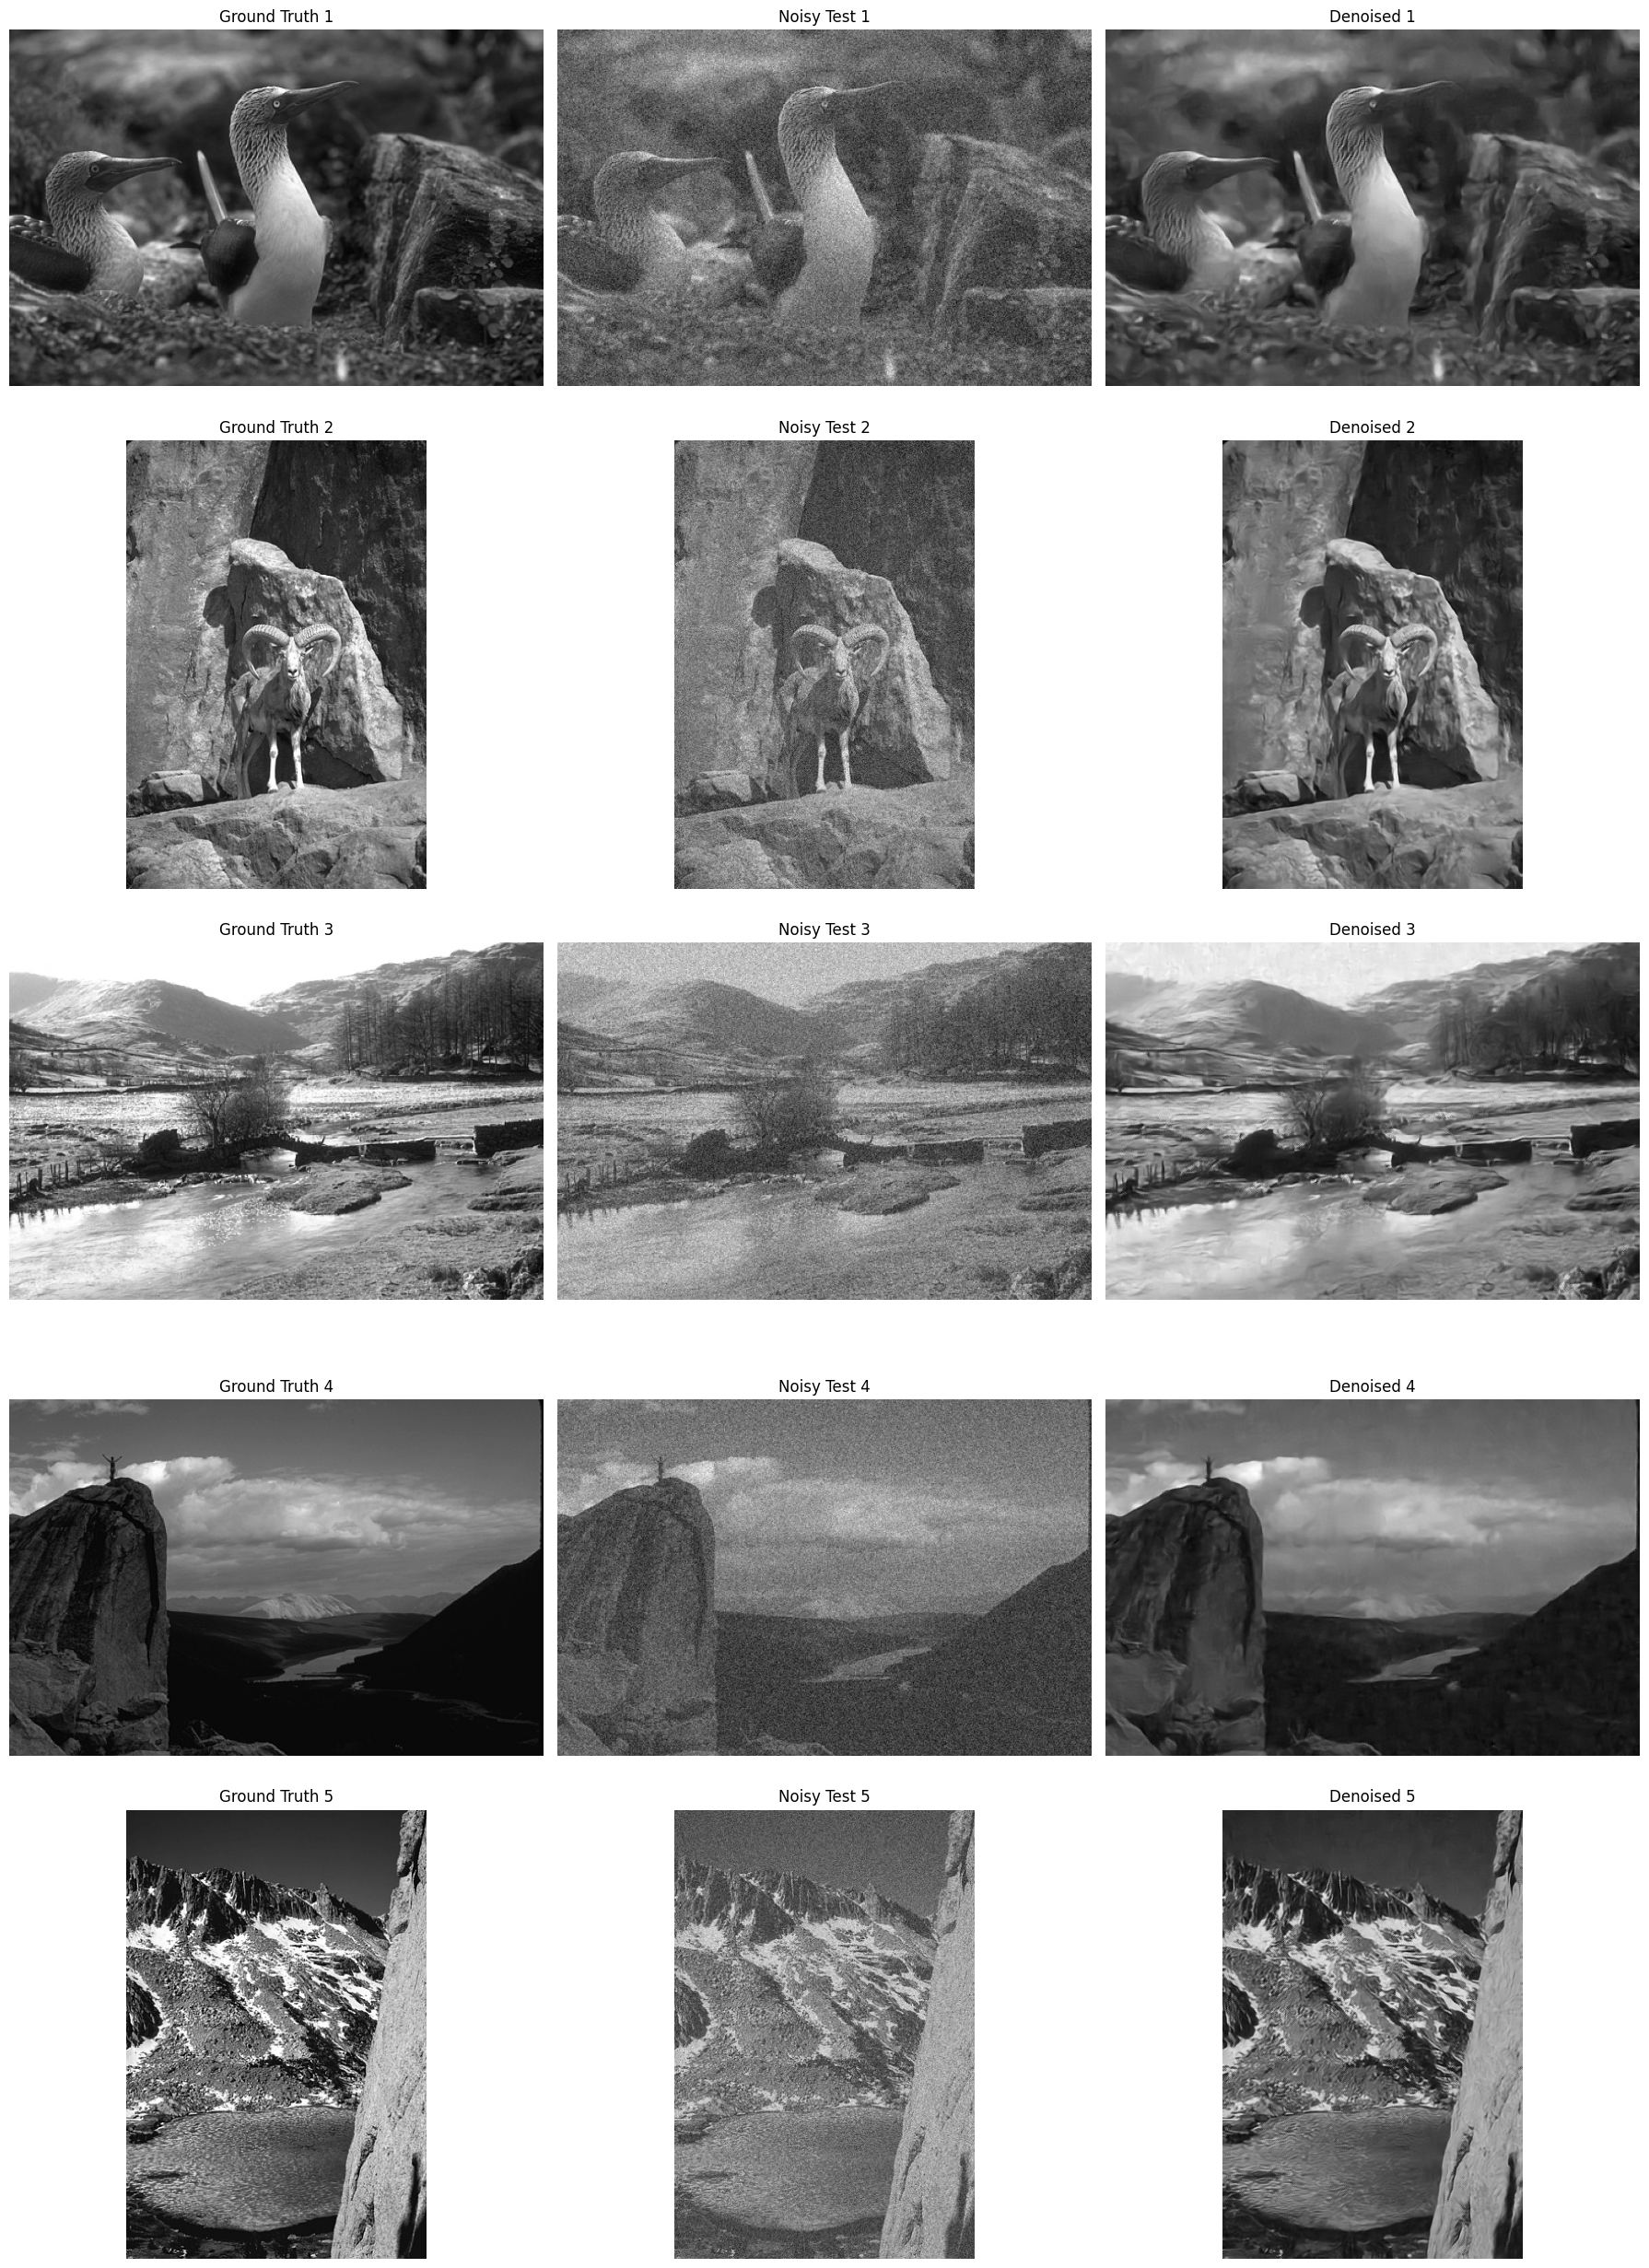

In [30]:
display_ground_truth_test_denoised(groundtruth_data, test_data, pred, num_samples=5)

In [53]:
greyscale_specs = np.load("../data/image_segmentation/data/greyscale_train/greyscale.npz")['np_data']

In [54]:
greyscale_specs.shape

(2685, 180, 180, 1)

In [55]:
spec_preds = []
for i, img in enumerate(greyscale_specs):
    pred = model.predict(img, axes='YXC')
    spec_preds.append(pred)

    if i == 100:
        break

The input image is of type float64 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 122ms/step
The input image is of type float64 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 36ms/step
The input image is of type float64 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 41ms/step
The input image is of type float64 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 30ms/step
The input image is of type float64 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 34ms/step
The input image is of type float64 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 33ms/step
The input image is of type float64 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 41ms/step
The input image is of type float64 and will be casted to float32 for

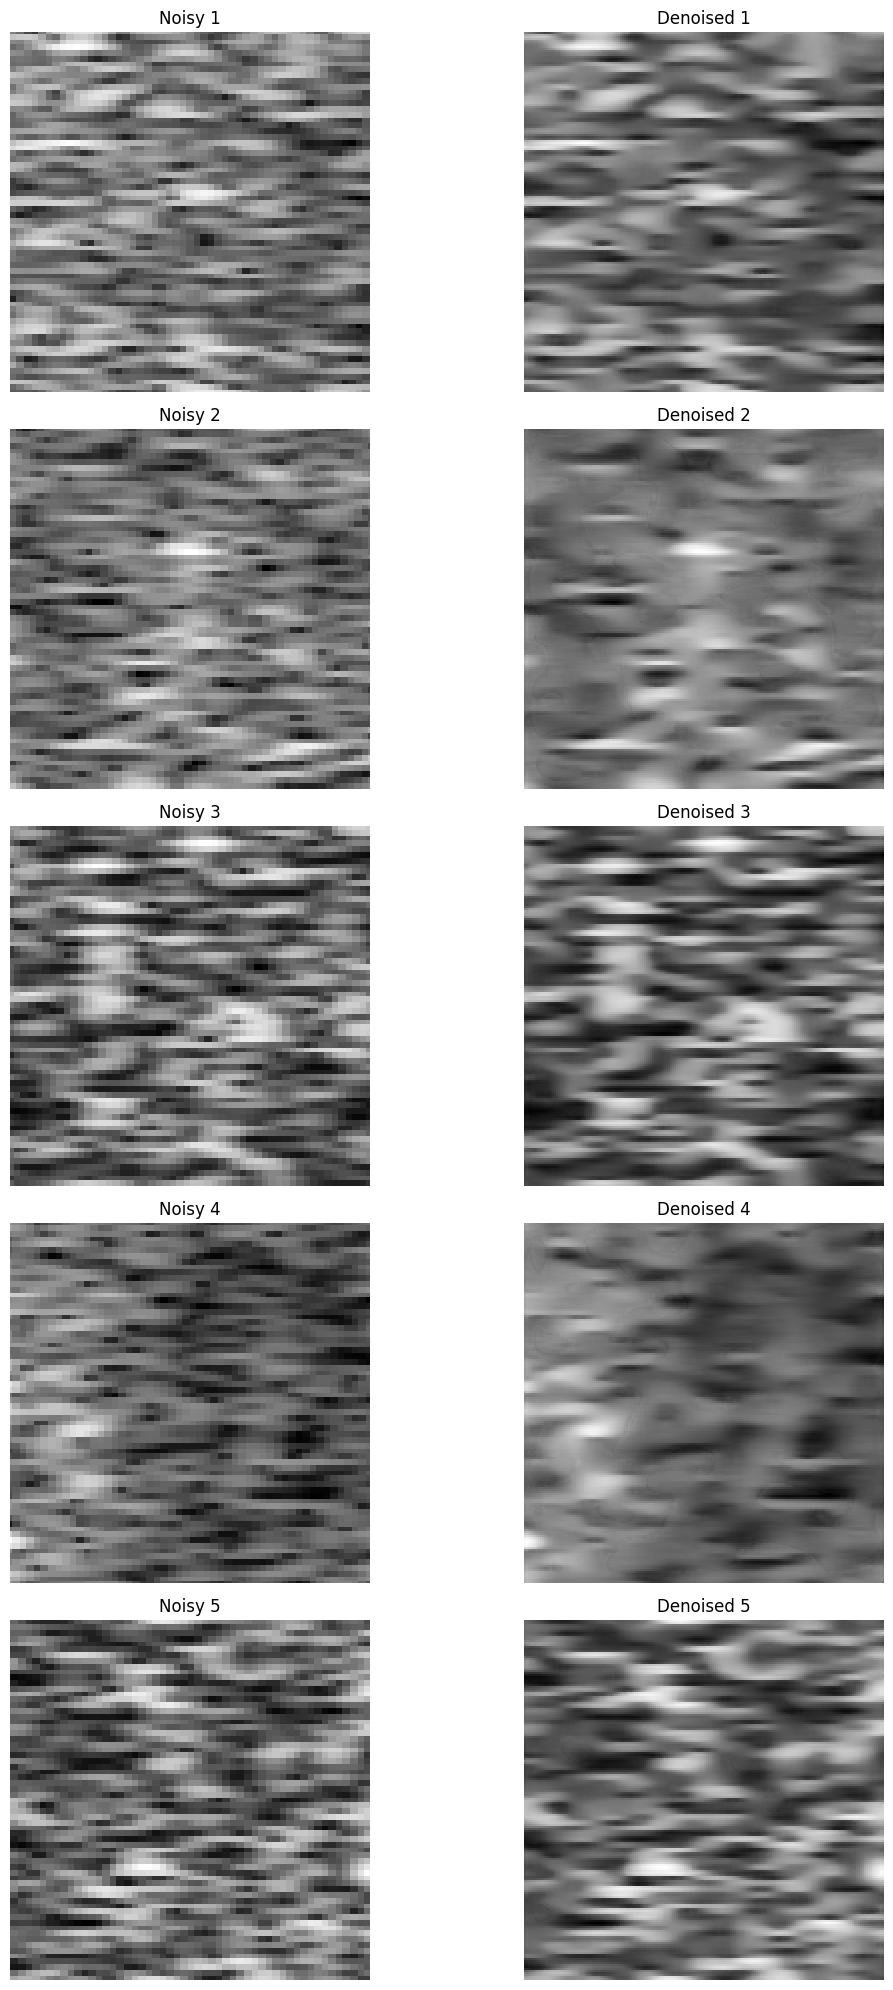

In [56]:
def display_noisy_and_denoised(noisy_data, denoised_data, num_samples=5):
    num_samples = min(num_samples, len(noisy_data))
    plt.figure(figsize=(12, 4 * num_samples))
    
    for i in range(num_samples):
        plt.subplot(num_samples, 2, 2 * i + 1)
        plt.imshow(noisy_data[i], cmap='gray')
        plt.title(f'Noisy {i+1}')
        plt.axis('off')

        plt.subplot(num_samples, 2, 2 * i + 2)
        plt.imshow(denoised_data[i], cmap='gray')
        plt.title(f'Denoised {i+1}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

display_noisy_and_denoised(greyscale_specs, spec_preds)